In [7]:
## MODFIED BY CHUYAN, for final project report of class, ATSC5040, Climate Sci. Constraint Works

import netCDF4
from numpy import *
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from get_LWPCMIP6data import *
from get_annual_so import *
from calc_LRM_metrics import *
from fitLRM_cy import *
from run_simple_cmip6 import *
from calc_slope import *

from scipy.optimize import curve_fit

In [8]:
#..retrieve MAC-nasa data for "LWP" & "TWP = LWP + rain water"


fn1_mac = '/glade/work/chuyan/Course_CliScience/maclwp_cloudlwpave_'
fn2_mac = '/glade/work/chuyan/Course_CliScience/maclwp_totallwpave_'

tt = arange(1992, 2017)
print(tt)

data_LWP_mac = []
data_TWP_mac = []

for t in arange(len(tt)):
    #..append 'LWP' & 'total water path = LWP + rain water' for MAC data from 1992 to 2016, monthly    
    data_LWP_mac.append(xr.open_dataset(fn1_mac+ str(tt[t])+ '_v1.nc4', decode_times=False)['cloudlwp'].values)
    
    data_TWP_mac.append(xr.open_dataset(fn2_mac+ str(tt[t])+ '_v1.nc4', decode_times=False)['totallwp'].values)

LWP_mac =  np.array(data_LWP_mac)
TWP_mac =  np.array(data_TWP_mac)

dataout_LWP_MAC  =   concatenate(LWP_mac, axis=0)
dataout_TWP_MAC  =   concatenate(TWP_mac, axis=0)

#.Convert units --> kg m-2
dataout_LWP_MAC = dataout_LWP_MAC / 1000.
dataout_TWP_MAC = dataout_TWP_MAC / 1000.



mac_twp_datayr14  =  xr.open_dataset('/glade/work/chuyan/Course_CliScience/maclwp_totallwpave_2014_v1.nc4',decode_times=False)

print(array(mac_twp_datayr14['totallwp'].values).shape)


#..define dimension/coordinates for MAC 25-yrs-data

lat_mac =  array(mac_twp_datayr14.coords['lat'])
lon_mac =  array(mac_twp_datayr14.coords['lon'])
times_mac = arange('1992-01-01', '2017-01-01', dtype='datetime64[M]')


#.. from 40 S ~ 85 S
lat0  = -85.
latmac0 = min(range(len(lat_mac)), key=lambda i:abs(lat_mac[i]-lat0))
lat1  = -40.
latmac1 = min(range(len(lat_mac)), key=lambda i:abs(lat_mac[i]-lat1))
print(latmac0, latmac1)

#.. lat dimension and data_LWP & data_TWP from 40 S ~ 85 S
lat_mac   =  lat_mac[latmac0:latmac1+1]
print(lat_mac.shape)

LWP_MAC  =  dataout_LWP_MAC[:, latmac0:latmac1+1, :]   #.. Units in kg m-2
TWP_MAC  =  dataout_TWP_MAC[:, latmac0:latmac1+1, :]   # 25 yrs Monthly 40~85 1*1 degree data, shapes in (300, 46, 360)



#..find the 'nan' point indexs in 3 dimensions
#ind_lwp  = isnan(LWP_MAC[3,:,:]) == True
#indm_false  = nonzero(ind_lwp ==True)

#mask_array = full((300,46,360), 1.0)
#mask_array[indm_false] = 0.0
#print(array(indm_false).shape)


print(nanmean(TWP_MAC), LWP_MAC.shape)

[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
(12, 180, 360)
4 49
(46,)
0.09612592 (300, 46, 360)


In [9]:
f_era5_singlele    =  xr.open_dataset('/glade/work/chuyan/Course_CliScience/era5_monthly_single_19922016.grib', engine='pynio')

f_era5_pressurele  =   xr.open_dataset('/glade/work/chuyan/Course_CliScience/era5_monthly_pressure_19922016.grib', engine='pynio')

print(f_era5_pressurele['lv_ISBL1'])

<xarray.DataArray 'lv_ISBL1' (lv_ISBL1: 9)>
array([ 250,  300,  500,  600,  700,  850,  900,  950, 1000], dtype=int32)
Coordinates:
  * lv_ISBL1  (lv_ISBL1) int32 250 300 500 600 700 850 900 950 1000
Attributes:
    long_name:  isobaric level
    units:      hPa


In [10]:
#..retrive ERA5 Reanalysis data

lwp   =  f_era5_singlele['TCLW_GDS0_SFC_S123'][:, ::-1,:]   #..Units in kg m^-2
iwp   =  f_era5_singlele['TCIW_GDS0_SFC_S123'][:, ::-1,:]   #..Units in kg m^-2
ps   =  f_era5_singlele['SP_GDS0_SFC_S123'][:, ::-1,:]      #..Units in 
prw  =   f_era5_singlele['TCWV_GDS0_SFC_S123'][:, ::-1,:]   #..Units in kg m^-2 , shape in (721, 1440, 300)
tas  =   f_era5_singlele['2T_GDS0_SFC_S123'][:, ::-1, :]    #.. 2-m surface -air Temp, K
E     =  f_era5_singlele['E_GDS0_SFC_S130'][:, ::-1,:]   #..Evaporation, in m /d
MC    =  f_era5_singlele['VIMD_GDS0_SFC_S130'][:, ::-1,:]  #..Moisture convergence, not in flux, units in kg m^-2
P     =  f_era5_singlele['TP_GDS0_SFC_S130'][:, ::-1,:]     #。。Precip
ts    =  f_era5_singlele['SKT_GDS0_SFC_S123'][:, ::-1,:]   #..surface temperatur, or skin Temperture, in K

ta   =  f_era5_pressurele['T_GDS0_ISBL_S123'][:, :, ::-1,:]
T_700  =  ta[:, 4, :, :]                           #..700mb Temperature, units in K
wap  =   f_era5_pressurele['W_GDS0_ISBL_S123'][:, 2, ::-1,:]   #..500mb Subsidence, Pa s**-1

lat_era1  = array(f_era5_singlele.coords['g0_lat_1'][::-1])
lon_era2  = array(f_era5_singlele.coords['g0_lon_2'])

lat_era2  = array(f_era5_pressurele.coords['g0_lat_2'][::-1])
lon_era3  = array(f_era5_pressurele.coords['g0_lon_3'])
#print(lat_era1, lat_era2)

for j in arange(len(lon_era2)):
    if lon_era3[j]!= lon_era2[j]:
        print('aha')

#.prove to be the same coordinates(dimensions)



#.. from 40 S ~ 85 S
lat0  = -85.
late0 = min(range(len(lat_era1)), key=lambda i:abs(lat_era1[i]-lat0))
lat1  = -40.
late1 = min(range(len(lat_era1)), key=lambda i:abs(lat_era1[i]-lat1))
lat_era   =   lat_era1[late0:late1+1]

lon_era   =   lon_era2
print(lat_era.shape)

#.. dataout_ERA5 from 40S ~ 85S: 
lwp  = lwp[:, late0:late1+1, :]   #..Units in kg m^-2
iwp  = iwp[:, late0:late1+1, :]   #..Units in kg m^-2
ps  = ps[:, late0:late1+1,: ]   #..Units in 
prw   =  prw[:, late0:late1+1,: ]   #..Units in kg m^-2 , shape in (721, 1440, 300)
tas   =  tas[:,:,:]  #.. 2-m surface -air Temp, K, for global region data
E   =   E[:, late0:late1+1,: ]  #..Evaporation, in m / day
MC   =  MC[:, late0:late1+1,: ]  #..Moisture convergence, not in flux, units in kg m^-2
P   =   P[:, late0:late1+1,: ] #。。Precip, in m / day
ts  =  ts[:, late0:late1+1,: ]  #..surface temperatur, or skin Temperture, in K

T_700  =  T_700[:, late0:late1+1,: ]   #..700mb Temperature, units in K
wap   =   wap[:, late0:late1+1,: ]    #..500mb Subsidence, Units in Pa s**-1


#..  Is ther any 'nan' points?
inde_wap  = isnan(wap.values)==True
inde_false  = nonzero(inde_wap ==True)

#print(array(inde_false).shape)


#..print(T_700, wap)


(181,)


In [11]:
#.Output 4(6)CCFs in ERA5 data: SST, (p-e)/MC, LTS, SUB500, prw

p_e  =   array(P+E)* 1000. 
MoistureConv  =   array(MC) *(-1.)
SST  =  array(ts)

SUB  =   array(wap)
gmt  =   array(tas)

LWP_era   =  array(lwp)
IWP_era   =  array(iwp)

#..calc Lower Troposphere Stability, K ?
k  = 0.286
theta_700  = array(T_700)* (100000./70000.)**k

#print(theta_700_abr)

theta_skin = array(ts)* (100000./array(ps))**k
LTS  = theta_700 - theta_skin

ind_lts = isnan(LTS==True)
ind_false_lts  =   nonzero(ind_lts == True)
print(array(ind_false_lts).shape)

#..Total column water vapour, Units in kg m**-2
prw  = array(prw)

#print(nanmean(p_e), nanmean(MoistureConv))


(3, 0)


In [12]:
CCFs = {'SST_origin': SST, 'p_e_origin': p_e, 'MC_origin': MoistureConv, 'LTS_origin': LTS, 'SUB_origin': SUB,  'prw_origin': prw}

LWP  = {'LWP_era5': LWP_era, 'IWP_era5': IWP_era, 'LWP_mac': LWP_MAC, 'TWP_mac': TWP_MAC}

Vars_era = {'LWP_era5': LWP_era, 'IWP_era5': IWP_era,  'prw': prw, 'SST': SST, 'p_e': p_e, 'MC': MoistureConv, 'LTS': LTS, 'SUB': SUB}
Vars_mac =  {'LWP_mac': LWP_MAC, 'TWP_mac': TWP_MAC}


In [13]:
deck_naccf =  ['SST', 'p_e', 'MC', 'LTS', 'SUB']

deck_nalwp  =  ['LWP_era5', 'IWP_era5', 'LWP_mac',  'TWP_mac']

deck_nat    =  ['SST', 'p_e', 'MC', 'LTS', 'SUB', 'LWP_era5', 'IWP_era5', 'LWP_mac', 'prw', 'TWP_mac']

deck_era     = ['LWP_era5', 'IWP_era5',  'prw', 'SST', 'p_e', 'MC', 'LTS', 'SUB']

deck_mac     =  ['LWP_mac',  'TWP_mac']

#..prepare work
dict1_mac_yr  = {}
dict1_era_yr  = {}
dict1_gmt_yr = {}

shape_yr_mac  = LWP_MAC.shape[0]//12
shape_yr_era =  LWP_era.shape[0]//12

print(shape_yr_era, shape_yr_mac)

layover_yr_mac = zeros((len(deck_mac), shape_yr_mac, LWP_MAC.shape[1], LWP_MAC.shape[2]))
layover_yr_era  = zeros((len(deck_era), shape_yr_era, LWP_era.shape[1], LWP_era.shape[2]))


layover_yr_gmt  = zeros((shape_yr_era, gmt.shape[1], gmt.shape[2]))

for a in arange(len(deck_mac)):
    for i in range(shape_yr_mac):
        layover_yr_mac[a, i,:,:]  = nanmean(Vars_mac[deck_mac[a]][i*12:(i+1)*12,:,:], axis=0)
        
    dict1_mac_yr[deck_mac[a] +'_yr'] =  layover_yr_mac[a, :]
    print(deck_mac[a])

for b in arange(len(deck_era)):
    for j in range(shape_yr_era):
        layover_yr_era[b, j,:,:]  = nanmean(Vars_era[deck_era[b]][j*12:(j+1)*12, :,:], axis=0)
        #..calc for b times
        layover_yr_gmt[j, :,:]        =   nanmean(gmt[j*12:(j+1)*12, :,:], axis=0)

    dict1_era_yr[deck_era[b] +'_yr'] =  layover_yr_era[b, :]
    dict1_gmt_yr['gmt_yr']  =  layover_yr_gmt
    print(deck_era[b])
print('gmt_yr')
#print(dict1_era_yr['LWP_era5_yr'], dict1_mac_yr['LWP_mac_yr'])


    
ind_lwp_mac = isnan(dict1_mac_yr['LWP_mac_yr']) == True
ind_flase_mac = nonzero(ind_lwp_mac == True)

print(array(ind_flase_mac).shape)

25 25
LWP_mac
TWP_mac


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


LWP_era5
IWP_era5
prw
SST
p_e
MC
LTS
SUB
gmt_yr
(3, 161464)


In [14]:
#..calc bin box mean..

#..set area-mean range
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10


#..define dictionary to store '_yr_bin' data
dict1_yr_bin_mac  = {}
dict1_yr_bin_era  = {}
dict1_yr_bin_gmt  = {}

#..Annually variables in bin box: 
#lat_mac  = lat_mac
#lon_mac  = lon_mac
#lat_era =  lat_era
#lon_era =  lon_era
lat_era_origin  = lat_era1

#..First transfer finer_resolution data (era5) to coarse data (mac) resolution: 1_degree X 1_degree:
for a in arange(len(deck_era)):
    dict1_yr_bin_era[deck_era[a] + '_mediated_yr_bin'], lat_1dt1d, lon_1dt1d = binned_cySouthOCEAN(dict1_era_yr[deck_era[a] + '_yr'], lat_era, lon_era, 1)
    
    #..Second find the 'nan' point indexs in each time-specific 2 dimensions arrays for LWP_mac_yr:
    mask_lwp = isnan(dict1_mac_yr['LWP_mac_yr'])
    dict1_yr_bin_era[deck_era[a]+'_masked_yr_bin'] = ma.masked_array(dict1_yr_bin_era[deck_era[a]+'_mediated_yr_bin'], mask=mask_lwp)

#print(lon_era, lon_1dt1d)
#ind_flase_yr  = ma.count_masked(dict1_yr_bin_era['LWP_era5_masked_yr_bin'])
#print(ind_flase_yr)

#..Third calc the 5 *5 binned array for 'LWP_mac_yr':
for b in arange(len(deck_mac)):
    dict1_yr_bin_mac[deck_mac[b] +'_yr_bin']  =   binned_cySouthOcean5(dict1_mac_yr[deck_mac[b] +'_yr'], lat_mac, lon_mac)

#..Fourth calc the 5* 5  binned array for ERA5 data arrays:
for c in arange(len(deck_era)):
    dict1_yr_bin_era[deck_era[c] + '_yr_bin']  = binned_cySouthOcean5(dict1_yr_bin_era[deck_era[c]+'_masked_yr_bin'], lat_1dt1d, lon_1dt1d)
    
dict1_yr_bin_gmt['gmt_yr_bin']  =   binned_cyGlobal5(dict1_gmt_yr['gmt_yr'], lat_era_origin,  lon_era)

print(dict1_yr_bin_era['LWP_era5_yr_bin'].shape)   #..(25, 10, 73)
print(dict1_yr_bin_mac['LWP_mac_yr_bin'].shape)   #..(25, 10, 73)
print(dict1_yr_bin_gmt['gmt_yr_bin'].shape)   #..(25, 36,73)


(25, 10, 73)
(25, 10, 73)
(25, 36, 73)


In [15]:
#..calc the standard interannual-deviation of those CCFs
deck_CCFs  = ['SST', 'p_e', 'MC', 'LTS', 'SUB', 'prw']
std_ERA5 =  {}

for k in arange(len(CCFs)):
    #print(k)
    #print(deck_CCFs[k])
    std_ERA5[deck_CCFs[k] +'_origin']  =  nanstd(Vars_era[deck_CCFs[k]])
    std_ERA5[deck_CCFs[k] +'_yr_bin']  =  nanstd(dict1_yr_bin_era[deck_CCFs[k] +'_yr_bin'])
print(std_ERA5)



{'SST_origin': 20.490025, 'SST_yr_bin': 7.110029800081979, 'p_e_origin': 1.1695154, 'p_e_yr_bin': 0.717819666256945, 'MC_origin': 1.2203293, 'MC_yr_bin': 0.7159566102694211, 'LTS_origin': 6.080506, 'LTS_yr_bin': 1.830669757817939, 'SUB_origin': 0.04367107, 'SUB_yr_bin': 0.013315662977697105, 'prw_origin': 5.398625, 'prw_yr_bin': 3.7509316370135104}


In [16]:
#..how much 'nan' points in LWP_mac?

ind_MAC_lwp  = isnan(dict1_yr_bin_mac['LWP_mac_yr_bin'])== True

ind_false_maclwp =  nonzero(ind_MAC_lwp ==True)

print(array(ind_false_maclwp).shape)

#ind_MAC_twp  = isnan(dict1_yr_bin_mac['TWP_mac_yr_bin'])== True

#ind_false_mactwp =  nonzero(ind_MAC_twp ==True)
#print(array(ind_false_mactwp).shape)

#..interesting array for ERA5 data
mask_array_LWP_era5 = dict1_yr_bin_era['LWP_era5_yr_bin']
mask_array_LWP_era5[ind_false_maclwp]  =   nan
#print(mask_array_LWP_era5)



(3, 3545)


In [17]:
TR_sst  = 0.0

dict2_predi_fla_mac = {}
dict2_predi_fla_era = {}

dict2_predi_nor_era = {}
dict2_predi_nor_mac = {}

#..Ravel binned array /Standardized data ARRAY :
for b in arange(len(deck_era)):
    dict2_predi_fla_era[deck_era[b]] = dict1_yr_bin_era[deck_era[b] +'_yr_bin'].flatten()
dict2_predi_fla_era['gmt'] = dict1_yr_bin_gmt['gmt_yr_bin'].flatten()

#.Normalized the predict array:

for b in arange(len(deck_era)):
    dict2_predi_nor_era[deck_era[b]] = (dict2_predi_fla_era[deck_era[b]] - nanmean(dict2_predi_fla_era[deck_era[b]]) )/ nanstd(dict2_predi_fla_era[deck_era[b]]) 
    

dict2_predi_nor_era['gmt'] =  (dict2_predi_fla_era['gmt'] - nanmean(dict2_predi_fla_era['gmt'] ))/ nanstd(dict2_predi_fla_era['gmt'])



for c in arange(len(deck_mac)):
    dict2_predi_fla_mac[deck_mac[c]]  =  dict1_yr_bin_mac[deck_mac[c] +'_yr_bin'].flatten()
# normalized the predict array

for d in arange(len(deck_mac)):
    dict2_predi_nor_mac[deck_mac[d]]  =   (dict2_predi_fla_mac[deck_mac[d]] - nanmean(dict2_predi_fla_mac[deck_mac[d]] ))// nanstd(dict2_predi_fla_mac[deck_mac[d]])

#..Use area_mean method, 'np.repeat' and 'np.tile' to reproduce gmt area-mean Array as the same shape as other flattened variables:
GMT  = area_mean(dict1_yr_bin_gmt['gmt_yr_bin'],  s_range,  x_range)   #..ALL in shape : shape_yr_abr(single dimension)
dict2_predi_fla_era['gmt']  = GMT.repeat(730)

# CCF conditions:
#..Subtract 'nan' in data, shape1 -> shape2(without 'nan' number) points and shape5('nan' number)

ind1 = ~isnan(dict2_predi_fla_mac['LWP_mac'])

ind_true = nonzero(ind1==True)
ind_false = nonzero(ind1==False) 
print('shape1: ', ind1.shape)
#..Sign the the indexing into YB, or YB value will have a big changes
print('shape2: ', array(ind_true).shape)        # shape2


#..Split data points with skin Temperature largerorEqual /Smaller than TR_sst: 

# shape1 split into shape3(larger.equal.Tr_sst) & shape4(smaller,Tr_sst)

ind_sst_le  = nonzero(dict2_predi_fla_era['SST'] >= TR_sst)
ind_sst_st  = nonzero(dict2_predi_fla_era['SST'] <  TR_sst)

# shape6:the intersection of shape2 and shape3, places where has LTS value and skin_T >= Threshold
ind6  = intersect1d(ind_true, ind_sst_le)
print('shape6: ', ind6.shape)   #.. points, shape6
# shape7:the intersection of shape5 and shape4, places have LTS value  but skin_T < Threshold
ind7  = intersect1d(ind_true, ind_sst_st)
print('shape7: ', ind7.shape)   #.. points, shape7


#..designate LWP single-array's value, MAC
YB_lwp_mac =  full(dict2_predi_fla_mac['LWP_mac'].shape, 0.0)
#YB_lwp_mac[ind_false] =  dict2_predi_fla_mac['LWP_mac'][ind_false]   #..LWP single-column array with no LTS points as original values, with has LTS value points as 0.0.
YB_lwp_mac  = ma.masked_array(YB_lwp_mac, mask= isnan(dict2_predi_fla_mac['LWP_mac']))

YB_twp_mac =  full(dict2_predi_fla_mac['TWP_mac'].shape, 0.0)
#YB_twp_mac[ind_false] =  dict2_predi_fla_mac['TWP_mac'][ind_false]
YB_twp_mac  = ma.masked_array(YB_twp_mac, mask= isnan(dict2_predi_fla_mac['TWP_mac']))

#..designate LWP single-array's value, ERA5
YB_lwp_era =  full(dict2_predi_fla_era['LWP_era5'].shape, 0.0)
#YB_lwp_era[ind_false] =  dict2_predi_fla_era['LWP_era5'][ind_false]
YB_lwp_era  = ma.masked_array(YB_lwp_era, mask= isnan(dict2_predi_fla_era['LWP_era5']))


YB_iwp_era =  full(dict2_predi_fla_era['IWP_era5'].shape, 0.0)
#YB_iwp_era[ind_false] =  dict2_predi_fla_era['IWP_era5'][ind_false]
YB_iwp_era  = ma.masked_array(YB_iwp_era, mask= isnan(dict2_predi_fla_era['IWP_era5']))

print(YB_iwp_era)

shape1:  (18250,)
shape2:  (1, 14705)
shape6:  (14705,)
shape7:  (0,)
[-- -- -- ... 0.0 0.0 0.0]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


In [18]:
#.. Multiple linear regreesion of Liquid Water Path to CCFs:

#..Remove abnormal and missing_values, train model with TR sst>= TR_sst, unit in K
X  = np.array( [dict2_predi_fla_era['SST'][ind6], dict2_predi_fla_era['p_e'][ind6], dict2_predi_fla_era['LTS'][ind6], dict2_predi_fla_era['SUB'][ind6]] )

regr1 = linear_model.LinearRegression()
result1 = regr1.fit(X.T, dict2_predi_fla_mac['LWP_mac'][ind6] )   #..regression for MAC- LWP data WITH LTS and skin-T >= TR_sst  

regr2 = linear_model.LinearRegression()
result2 = regr2.fit(X.T, dict2_predi_fla_era['LWP_era5'][ind6] )   #..regression for ERA5-LWP data WITH LTS and skin-T >= TR_sst

if len(ind7)!=0:
    XX  = np.array( [dict2_predi_fla_era['SST'][ind7], dict2_predi_fla_era['p_e'][ind7], dict2_predi_fla_era['LTS'][ind7], dict2_predi_fla_era['SUB'][ind7]] )

    regr3 = linear_model.LinearRegression()
    result3 = regr3.fit(XX.T, dict2_predi_fla_mac['LWP_mac'][ind7])  #..regression for MAC- LWP data WITH LTS and skin-T >= TR_sst  

    regr4 = linear_model.LinearRegression()
    result4 = regr4.fit(XX.T, dict2_predi_fla_era['LWP_era5'][ind7])  #..regression for ERA5-LWP data WITH LTS and skin-T >= TR_sst


#..ADD dec9TH: calc ERA5_IWP
regr1_iwp = linear_model.LinearRegression()
result1_IWP = regr1_iwp.fit(X.T, dict2_predi_fla_era['IWP_era5'][ind6])   #..regression for Ice Water Path with having 'LTS' values

print(nanmean(dict2_predi_fla_era['LWP_era5']), nanmean(dict2_predi_fla_mac['LWP_mac']))

0.06306396458150143 0.07844350320763263


In [19]:
aeffi  = result1.coef_
aint   = result1.intercept_

beffi  = result2.coef_
bint   = result2.intercept_

if len(ind7)!=0:
    ceffi  = result3.coef_
    cint   = result3.intercept_

    deffi  = result4.coef_
    dint   = result4.intercept_
else:
    ceffi  = full(4, 0.0)
    cint   = 0.0
    
    deffi  = full(4, 0.0)
    dint   = 0.0

effi_iwp  = result1_IWP.coef_
int_iwp   = result1_IWP.intercept_

print('result1 coefZ&int(lwplesst case6): ', aeffi, aint)
print('result3 coef(lwpltsst case7): ', ceffi, cint)

result1 coefZ&int(lwplesst case6):  [0.002332   0.01041871 0.00354989 0.02709724] -0.6243784813608335
result3 coef(lwpltsst case7):  [0. 0. 0. 0.] 0.0


In [20]:
deck_nas  = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'E3SM10', 'GFDLCM4', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0']

SAM0={'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

if (exp=='piControl')|(exp=='amip'):

    MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
    CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f3', 'gg': 'gn', "typevar": 'Amon'}   #  Be careful, failure due to 'day time representation'
UKESM10 = {'modn': 'UKESM1-0-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}   # the same day time representation issue as 'HadGem3', dont have 'wap' variable in 'pi-Control' exp
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM6 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}# time doesn't corresponding for 'evspsbl' in  'pi-Control' exper

CNRMESM2 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MIROCES2L= {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}#


GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}# missing lots of Variables
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
ACCESSCM2 = {'modn': 'ACCESS-CM2', 'consort': 'CSIRO-ARCCSS', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' don't have 'Amon' typevar
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#  abrupt4x exper doesnt have 'ps' variable in r1i1p1f1
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
INM_CM50 = {'modn': 'INM-CM5-0', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar

NORESM2LM = {'modn': 'NorESM2-LM', 'consort': 'NCC', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}# missing a lot of variables and typevars
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}# time doesnt corresponding, lose a lot of files for different variables in both exper
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'tas' variable
CMCC = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6',
        'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..'/glade/' dont have 'abrupt-4xCO2'/'piControl' exper
ECE = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..dont have 'Amon' or variable 'tas'
#ECE has different variants for exper
ECEV = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}#..too hard to operate

#ECEV has very discrete year in 'abrupt-4xCO2', semms continued but each in one yr file in 'piControl'
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}# '/glade/' dont have 'Amon' typever in 'abru4x'


deck  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, E3SM10, GFDLCM4, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]

output_ARRAY = {}
output_intermedia = {}
output_GMT =  {}
output_predict  = {}
output_report   = {}

output_LRM_st =  {}
output_LRM_le = {}
shape_yr_modelPI =  {}
shape_yr_modelabr = {}

fpath= '/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/'
Tr_sst = 270.0

for i in range(len(deck)):
    
    output_ARRAY[deck_nas[i]] =  load(fpath+ deck[i]['modn']+'_'+str(Tr_sst)+'_dats.npz', allow_pickle=True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas[i]]  = output_ARRAY[deck_nas[i]]['rawdata_dict']
    
    output_GMT[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['GMT']
    output_predict[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['predict_lwp']
    output_report[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['report_lwp']

    output_LRM_st[deck_nas[i]] =  output_intermedia[deck_nas[i]][()]['LRM_st']
    output_LRM_le[deck_nas[i]] =  output_intermedia[deck_nas[i]][()]['LRM_le']

print(output_LRM_st)
print(output_LRM_le)

{'BCCESM1': (array([ 0.00216513,  0.0529142 , -0.00226322, -0.16395905]), -0.47290462534392547), 'CanESM5': (array([ 0.00076223,  0.01452639, -0.00060506,  0.08695137]), -0.1733882927668349), 'CESM2': (array([ 0.00250681,  0.01176631, -0.00115052,  0.22802177]), -0.5710825478547076), 'CESM2FV2': (array([ 0.00237242,  0.0016509 , -0.00118486,  0.28344172]), -0.5370708231759176), 'CESM2WACCM': (array([ 0.0025006 ,  0.0114107 , -0.00107414,  0.2368444 ]), -0.5703001287407605), 'CNRMESM2': (array([ 0.00060181,  0.00690876, -0.00039253,  0.06670461]), -0.13814947835787664), 'E3SM10': (array([ 0.00202245,  0.00623168, -0.00107055,  0.12361906]), -0.460338961218743), 'GFDLCM4': (array([ 0.0008489 ,  0.00850805, -0.00054017,  0.09718744]), -0.19408430026984877), 'GISSE21G': (array([ 0.00237053,  0.02599963, -0.00095831, -0.03957447]), -0.5521029708400826), 'GISSE21H': (array([ 0.00257921,  0.0288887 , -0.00057164, -0.07656177]), -0.6119933506809697), 'IPSLCM6ALR': (array([ 0.00092387,  0.00358

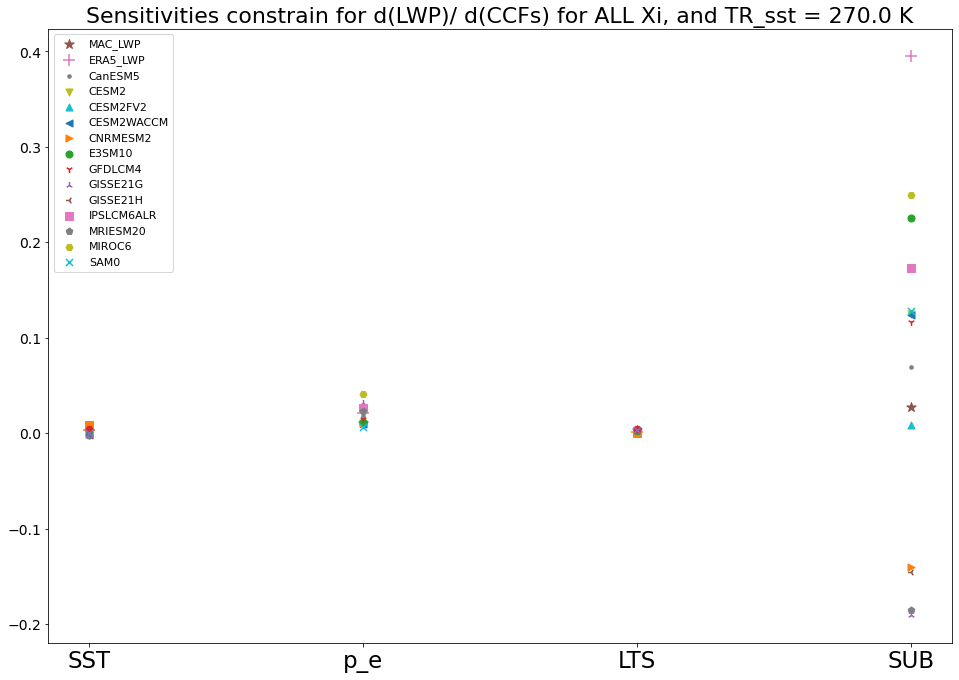

In [30]:
import seaborn as sns
from collections import OrderedDict

fig3  = plt.figure(figsize =(16.2, 11.3))  #(16.2, 9.3))
ax3  = plt.axes()
parameters = {'axes.labelsize': 22, 'legend.fontsize': 11,
          'axes.titlesize': 22, 'xtick.labelsize': 23, 'ytick.labelsize':14}
plt.rcParams.update(parameters)

fn_path_plots2 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test2/'
X = arange(4)
XX = ['SST', 'p_e', 'LTS', 'SUB']

deck_marker = [',', '.', 'v', '^', '<', '>', 'o', '1', '2', '3', 's', 'p', 'H', 'x', 'D', 'h', '4', 'd']

for i in arange(4):
    
    dot1 = plt.scatter(XX[i], aeffi[i], label = 'MAC_LWP', marker='*', s=100)
    dot2 = plt.scatter(XX[i], beffi[i], label = 'ERA5_LWP', marker='+', s=130)
    for j in arange(len(deck_nas)):
        if deck_nas[j]!= 'BCCESM1':
            dot0 = plt.scatter(XX[i], output_LRM_le[deck_nas[j]][0][i], marker=deck_marker[j], s=50, label=deck_nas[j])
    
    
    
#plt.xlabel(XX[i])
handles, labels = plt.gca().get_legend_handles_labels()
#.."by_labels" is an Oredered Dictionary which contains 'key':labels, 'values': handles
by_labels =  OrderedDict(zip(labels, handles))


plt.legend(by_labels.values(), by_labels.keys())
plt.title('Sensitivities constrain for d(LWP)/ d(CCFs) for ALL Xi' + ', and TR_sst = ' + str(Tr_sst)+' K')
plt.savefig(fn_path_plots2+ '4CCFs: Sensitivity constraint_ 270K')

#..plt.cla()   #..clear current axes
#print(by_labels.values)

In [26]:
from scipy.optimize import curve_fit

def target_func(x, m, k):
    '''
    1-d line linear fit
    '''
    
    y = m*x+ k
    
    return y

#..set are-mean range and define functio
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10


output_predi_fla_PI =  {}
output_predi_fla_abr  ={}
areamean_dict_predi   = {}
output_obsercoef_predi  = {}
for i in range(len(deck)):
    #if deck_nas[i]  !=   'BCCESM1':
    output_predi_fla_PI[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['dict2_predi_fla_PI']
    output_predi_fla_abr[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['dict2_predi_fla_abr']
    X_pi  = np.array( [output_predi_fla_PI[deck_nas[i]]['SST'], output_predi_fla_PI[deck_nas[i]]['p_e'], output_predi_fla_PI[deck_nas[i]]['LTS'], output_predi_fla_PI[deck_nas[i]]['SUB']])
    X_abr = np.array( [output_predi_fla_abr[deck_nas[i]]['SST'], output_predi_fla_abr[deck_nas[i]]['p_e'], output_predi_fla_abr[deck_nas[i]]['LTS'], output_predi_fla_abr[deck_nas[i]]['SUB']])
    # Regression for pi VALUES:
    sstlelwp_pi = dot(aeffi.reshape(1, -1), X_pi)  + aint   

    # Regression for abr VALUES:
    sstlelwp_abr  = dot(aeffi.reshape( 1,-1), X_abr) + aint

    #..back to the '_yr_bin' shape, for pi
    LWP_predi_bin_PI   =  array(sstlelwp_pi).reshape(shape_yr_modelPI[deck_nas[i]], 10, 73)

    #...back to the '_yr_bin' shape, for pi                                    
    LWP_predi_bin_abr   =  array(sstlelwp_abr).reshape(shape_yr_modelabr[deck_nas[i]], 10, 73)

    #..calc area meaned lwp data for pi&abr in GCMs:
    areamean_dict_predi[deck_nas[i]+'_LWP_area_yr_pi']  =   area_mean(LWP_predi_bin_PI, y_range, x_range)
    areamean_dict_predi[deck_nas[i]+'_LWP_area_yr_abr']  =   area_mean(LWP_predi_bin_abr, y_range, x_range)

    # predicted values, from pi-Control to abrupt4xCO2 experiment

    predict_lwp  = full((shape_yr_modelPI[deck_nas[i]] + shape_yr_modelabr[deck_nas[i]]), 0.0)
    predict_lwp[0:shape_yr_modelPI[deck_nas[i]]]  =   areamean_dict_predi[deck_nas[i]+'_LWP_area_yr_pi']
    predict_lwp[shape_yr_modelPI[deck_nas[i]]:]  =   areamean_dict_predi[deck_nas[i]+'_LWP_area_yr_abr']

    #..put the predict lwp data for 11GCMs by Observation Southern Ocean coef, into the output dictionary
    output_obsercoef_predi[deck_nas[i]] =    predict_lwp
print(output_obsercoef_predi[deck_nas[0]])

KeyError: 'BCCESM1'

KeyError: 'CanESM5'

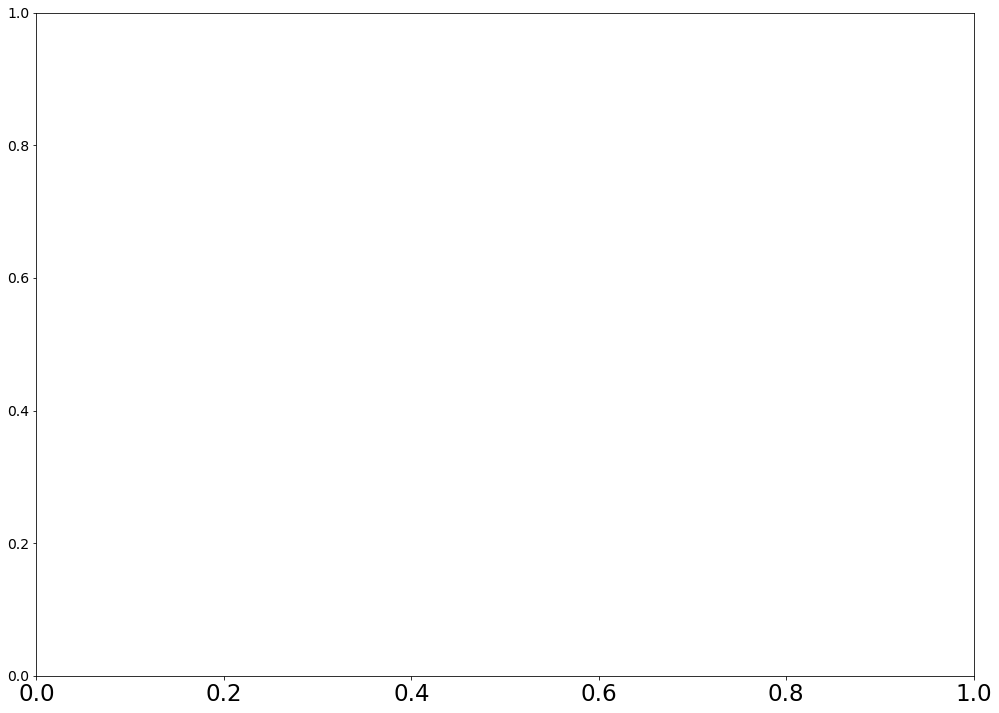

In [25]:
#..D(lwp) for GCM report values and 2LRM model predict values

fig6  = plt.figure(figsize =(16.8, 12.2))  #(16.2, 9.3))
ax6  = plt.axes()

x =  arange(-0.003 ,0.045, 0.003)
y =  x

deck_marker = [',', '.', 'v', '^', '<', '>', 'o', '1', '2', '3', 's', 'p', 'H', 'x', 'D', 'h', '4', 'd']

output_dabr_pi_report = {}
output_dabr_pi_predict = {}
output_dabr_pi_obspredi  = {}
output_yrs = {}
regr_data = []
report_data = []
yr         =             49
h = []
for a in range(len(deck)):
    
    
    if deck_nas[a]!= 'BCCESM1':
        output_yrs[deck_nas[a]]  = arange(shape_yr_modelabr[deck_nas[a]])   #..how many years for collected 'abr-4x' data
        
        output_dabr_pi_report[deck_nas[a]]  = output_report[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_report[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
        output_dabr_pi_predict[deck_nas[a]] =  output_predict[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_predict[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
    
        plt.scatter(output_dabr_pi_predict[deck_nas[a]][yr] ,output_dabr_pi_report[deck_nas[a]][yr], s = 110, marker = deck_marker[a], label = deck_nas[a])
        regr_data = append(regr_data, output_dabr_pi_predict[deck_nas[a]][yr])
        report_data = append(report_data, output_dabr_pi_report[deck_nas[a]][yr])

        #.. Observation (MAC_LWP) calced sensitivity for each of GCMs
        output_dabr_pi_obspredi[deck_nas[a]]  = output_obsercoef_predi[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_obsercoef_predi[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
        plt.scatter(output_dabr_pi_obspredi[deck_nas[a]][yr],  output_dabr_pi_report[deck_nas[a]][yr] , s = 125., label = deck_nas[a] + ' add OBS sensitivities')
        
        
        h = append(h, output_dabr_pi_obspredi[deck_nas[a]][yr])
###..linear curve fit for regressed d(LWP) and reported d(LWP):
POPT, POCV  = curve_fit(target_func, regr_data, report_data)

print(h)
#..Calc  the R square
calced_ydata = [target_func(x, POPT[0], POPT[1]) for x in regr_data]
residual_ydata = array(report_data) - array(calced_ydata)
ss_res       = sum(residual_ydata **2)
ss_tot       = sum((report_data - mean(report_data)) **2)

R_square  = 1 - (ss_res / ss_tot)

plt.plot(regr_data, POPT[0]*regr_data+POPT[1], label='fit line y = %.3f *x + %.4f, r^2=%.5f' % (POPT[0], POPT[1], R_square), c = 'red', linewidth = 0.8)
plt.plot(x ,y, label = 'reference line', c='blue', linestyle='--')
plt.plot(full(len(x), (min(h) - 0.0001)) ,y, linestyle = '--' , c = 'k', linewidth = 1.3)
plt.plot(full(len(x), (max(h) + 0.0001)) ,y, linestyle = '--' , c = 'k', linewidth = 1.3)
plt.xlabel('Regr delta(LWP), ' + r'$kg* m_{-2}$', fontsize= 15)
plt.ylabel('GCM delta(LWP), '+r'$kg*m_{-2}$', fontsize= 15)

plt.title("1LRM regressed d(LWP) and GCMs d(LWP), TR_sst = "+ str(Tr_sst) + ' at the %d yr of abr-4x'%(yr+1), fontsize =18)


plt.legend(loc='upper left',  fontsize= 9)


#..plt.savefig("2LRM_270_GCMs regression result_ %dth_ added OBS reg"% (yr+1))